In [1]:
# Start writing code here...

In [2]:
#Trading Strategy

#Long only, no short sales

#Bollinger Bands (BBANDS)
#Length:  30
#St Dev:  2

#RSI (Relative Strength Index)
#Upper Band:  75
#Lower Band:  25
#Length:  13

#Take Profit Amount
#600 bps (6.0%)

#Trailing Stop Loss
#Trailing stop loss is equal to the "Average True Range (ATR)" on any given day.
#ATR Definition:  The true range indicator is taken as the greatest of the following: 
#current high less the current low; 
#the absolute value of the current high less the previous close; 
#and the absolute value of the current low less the previous close. 
#The ATR is then a moving average, generally using 14 days, of the true ranges.

#Strategy Summary
#IF close price < bottom BBAND AND RSI < 25, LONG Entry
#IF price breaches the Average True Range on any given day, exit the long position


### Library Installations

In [3]:
!pip install alpaca_trade_api
!pip install finta
!pip install scikit-learn



  Using cached aiohttp-3.8.1-cp39-cp39-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (1.2 MB)
  Attempting uninstall: aiohttp
    Found existing installation: aiohttp 3.8.3
    Not uninstalling aiohttp at /shared-libs/python3.9/py-core/lib/python3.9/site-packages, outside environment /root/venv
    Can't uninstall 'aiohttp'. No files were found to uninstall.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


### Library Imports

In [4]:
# The installed libraries above should be import in this cell
import pandas as pd
import numpy as np
from finta import TA

# Ploting lib
import matplotlib.pyplot as plt

# Sci-kit learn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

# Alpaca imports 
import alpaca_trade_api as tradeapi

# Alpaca methods
from alpaca_trade_api.common import URL
from alpaca_trade_api.stream import Stream

# HTML components
from IPython.display import display, HTML

### Enviromental Viariables 

In [32]:
# Get evniromental variables from the VM settings

import os

API_KEY = os.environ.get('ALPACA_KEY')
SECRET_KEY = os.environ.get('ALPACA_SECRET')

print(API_KEY)
print(SECRET_KEY)


PKDAHUBMVEXZLEH3SU8H
Le9x0dEqq6rC6j0paojasdyiel8yDElAIyOLi9m2


### Alpaca SDK Connection

In [6]:
api = tradeapi.REST(
    API_KEY,
    SECRET_KEY,
    base_url=URL('https://paper-api.alpaca.markets')
)

account = api.get_account()

print(f"${format(float(account.cash), ',')}")


$97,560.42


### Alpaca ticker function

In [7]:
#Set up a function that will create a dataframe with Bollinger Bands and RSI for a given ticker

from alpaca_trade_api.rest import TimeFrame

def get_stock_data_with_indicators(ticker, start_date='2013-04-14', end_date='2023-04-14', timeframe='1H'):
    # Ensure the ticker is uppercase
    ticker = ticker.upper()

    # Convert start and end dates to timestamps with timezone
    start_date = pd.Timestamp(start_date, tz="America/New_York").isoformat()
    end_date = pd.Timestamp(end_date, tz="America/New_York").isoformat()

    # Download stock data
    stock_data = api.get_bars(ticker, TimeFrame.Hour, start=start_date, end=end_date).df

    # Reset the index and rename the index column to 'date'
    stock_data.reset_index(level=0, inplace=True)
    stock_data.rename(columns={"timestamp": "date"}, inplace=True)

    # Rename columns to match finta's requirements
    stock_data.rename(columns={"open": "Open", "high": "High", "low": "Low", "close": "Close", "volume": "Volume"}, inplace=True)

    # Calculate Bollinger Bands
    bbands = TA.BBANDS(stock_data)

    stock_data['bb_upper'] = round(bbands['BB_UPPER'], 2)
    stock_data['bb_middle'] = round(bbands['BB_MIDDLE'], 2)
    stock_data['bb_lower'] = round(bbands['BB_LOWER'], 2)

    # Calculate RSI
    stock_data['rsi'] = round(TA.RSI(stock_data, period=13), 2)

    # Drop rows with missing values
    stock_data.dropna(inplace=True)

    # Set the index back to the date
    stock_data.set_index('date', inplace=True)

    return stock_data

# Example usage
TSLA_data = get_stock_data_with_indicators('TSLA')
TSLA_data.head()







,Open,High,Low,Close,Volume,trade_count,vwap,bb_upper,bb_middle,bb_lower,rsi
date,,,,,,,,,,,
2015-12-02 17:00:00+00:00,235.1560,235.72,234.1902,234.330,346183,2757,234.916301,239.80,235.80,231.79,44.18
2015-12-02 18:00:00+00:00,234.2900,236.28,233.5400,234.775,367810,3125,234.926553,239.36,235.98,232.61,47.71
2015-12-02 19:00:00+00:00,234.8167,234.87,231.2300,231.650,367417,3552,232.794633,239.18,236.02,232.85,32.21
2015-12-02 20:00:00+00:00,231.6500,233.77,231.4800,231.970,568177,5282,232.567764,239.49,235.85,232.21,34.57
2015-12-02 21:00:00+00:00,231.9800,232.93,231.9800,232.400,80983,12,232.000636,239.59,235.81,232.02,37.72


In [8]:
RISKPERCENTAGE = 6

In [9]:
TICKER = 'GLD'

In [10]:
ticker_data = get_stock_data_with_indicators(TICKER)


In [11]:
ticker_data.head()

,Open,High,Low,Close,Volume,trade_count,vwap,bb_upper,bb_middle,bb_lower,rsi
date,,,,,,,,,,,
2015-12-02 18:00:00+00:00,100.83,101.030,100.799,100.99,1232353,4145,100.969263,103.03,101.86,100.69,26.92
2015-12-02 19:00:00+00:00,100.99,101.165,100.840,100.86,877351,3611,100.977767,103.00,101.78,100.56,25.05
2015-12-02 20:00:00+00:00,100.86,100.890,100.673,100.71,1471804,7284,100.770875,102.97,101.70,100.42,23.05
2015-12-02 21:00:00+00:00,100.69,100.830,100.650,100.80,308926,151,100.697394,102.94,101.63,100.32,26.85
2015-12-02 22:00:00+00:00,100.81,100.810,100.810,100.81,100,1,100.810000,102.84,101.54,100.25,27.28


### Ticker Graph / Bollinger Bands

In [12]:
# Reset index so that date can be access as x axis

ticker_graph = ticker_data.reset_index()

ticker_graph = ticker_graph.loc[ticker_graph["date"] > '2022-01-01']
ticker_graph.value_counts()


date                       Open     High      Low     Close    Volume   trade_count  vwap        bb_upper  bb_middle  bb_lower  rsi  
2022-01-03 07:00:00+00:00  170.210  170.2100  170.21  170.210  183      1            170.210000  171.34    170.39     169.44    49.88    1
2022-10-31 13:00:00+00:00  152.360  152.5600  152.07  152.425  1491858  6922         152.383860  153.74    152.97     152.20    33.82    1
2022-10-31 11:00:00+00:00  152.750  152.8799  152.55  152.550  7744     63           152.748536  153.92    153.10     152.28    35.45    1
2022-10-31 08:00:00+00:00  152.500  152.5000  152.29  152.290  8112     9            152.497418  154.16    153.19     152.23    28.87    1
2022-10-31 06:00:00+00:00  152.740  152.7400  152.72  152.720  400      2            152.730000  154.40    153.31     152.23    34.19    1
                                                                                                                                        ..
2022-05-27 21:00:00+00:00  172.8

In [13]:
# Display the output as an H1 heading
display(HTML(f'<h1>{TICKER} GRAPH</h1>'))

In [14]:
DeepnoteChart(ticker_graph, """{"layer":[{"layer":[{"mark":{"clip":true,"type":"trail","color":"#4c78a8","tooltip":true},"encoding":{"x":{"sort":"ascending","type":"temporal","field":"date","scale":{"type":"linear","zero":false}},"y":{"sort":null,"type":"quantitative","field":"Close","scale":{"type":"linear","zero":false},"format":{"type":"default","decimals":null},"formatType":"numberFormatFromNumberType"},"color":{"datum":"Close"}}},{"mark":{"size":100,"type":"point","opacity":0,"tooltip":true},"encoding":{"x":{"sort":"ascending","type":"temporal","field":"date","scale":{"type":"linear","zero":false}},"y":{"sort":null,"type":"quantitative","field":"Close","scale":{"type":"linear","zero":false},"format":{"type":"default","decimals":null},"formatType":"numberFormatFromNumberType"},"color":{"datum":"Close"}}}]},{"layer":[{"mark":{"clip":true,"type":"trail","color":"#f58518","tooltip":true},"encoding":{"x":{"sort":"ascending","type":"temporal","field":"date","scale":{"type":"linear","zero":false}},"y":{"sort":null,"type":"quantitative","field":"bb_lower","scale":{"type":"linear","zero":false},"format":{"type":"default","decimals":null},"formatType":"numberFormatFromNumberType"},"color":{"datum":"bb_lower"}}},{"mark":{"size":100,"type":"point","opacity":0,"tooltip":true},"encoding":{"x":{"sort":"ascending","type":"temporal","field":"date","scale":{"type":"linear","zero":false}},"y":{"sort":null,"type":"quantitative","field":"bb_lower","scale":{"type":"linear","zero":false},"format":{"type":"default","decimals":null},"formatType":"numberFormatFromNumberType"},"color":{"datum":"bb_lower"}}}]},{"layer":[{"mark":{"clip":true,"type":"trail","color":"#e45756","tooltip":true},"encoding":{"x":{"sort":"ascending","type":"temporal","field":"date","scale":{"type":"linear","zero":false}},"y":{"sort":null,"type":"quantitative","field":"bb_middle","scale":{"type":"linear","zero":false},"format":{"type":"default","decimals":null},"formatType":"numberFormatFromNumberType"},"color":{"datum":"bb_middle"}}},{"mark":{"size":100,"type":"point","opacity":0,"tooltip":true},"encoding":{"x":{"sort":"ascending","type":"temporal","field":"date","scale":{"type":"linear","zero":false}},"y":{"sort":null,"type":"quantitative","field":"bb_middle","scale":{"type":"linear","zero":false},"format":{"type":"default","decimals":null},"formatType":"numberFormatFromNumberType"},"color":{"datum":"bb_middle"}}}]},{"layer":[{"mark":{"clip":true,"type":"trail","color":"#83bcb6","tooltip":true},"encoding":{"x":{"sort":"ascending","type":"temporal","field":"date","scale":{"type":"linear","zero":false}},"y":{"sort":null,"type":"quantitative","field":"bb_upper","scale":{"type":"linear","zero":false},"format":{"type":"default","decimals":null},"formatType":"numberFormatFromNumberType"},"color":{"datum":"bb_upper"}}},{"mark":{"size":100,"type":"point","opacity":0,"tooltip":true},"encoding":{"x":{"sort":"ascending","type":"temporal","field":"date","scale":{"type":"linear","zero":false}},"y":{"sort":null,"type":"quantitative","field":"bb_upper","scale":{"type":"linear","zero":false},"format":{"type":"default","decimals":null},"formatType":"numberFormatFromNumberType"},"color":{"datum":"bb_upper"}}}]},{"layer":[{"mark":{"clip":true,"type":"bar","color":"#54a24b","tooltip":true},"encoding":{"x":{"axis":{"title":"Date / RSI"},"sort":"ascending","type":"temporal","field":"date","scale":{"type":"linear"}},"y":{"axis":{"title":"Close / Bollinger Band"},"sort":null,"type":"quantitative","field":"rsi","scale":{"type":"linear"},"format":{"type":"default","decimals":null},"aggregate":"sum","formatType":"numberFormatFromNumberType"}}}]}],"title":"","config":{"legend":{}},"$schema":"https://vega.github.io/schema/vega-lite/v5.json","encoding":{}}""")

In [15]:
# import pandas as pd

# ticker_graph_filtered = ticker_graph[ticker_graph["date"].dt.tz_localize(None).between(pd.to_datetime(1633264393772, unit='ms'), pd.to_datetime(1682425072980, unit='ms')) & ticker_graph["Close"].between(58.14485634823579, 449.39114714942275)]
# ticker_graph_filtered = ticker_graph_filtered[ticker_graph_filtered["date"].dt.tz_localize(None).between(pd.to_datetime(1648565616077, unit='ms'), pd.to_datetime(1682096811142, unit='ms')) & ticker_graph_filtered["Close"].between(124.91043498325064, 449.39114714942275)]
# ticker_graph_filtered

### Identify trading signals and ATR ('Average True Range') values

In [16]:
#Change 'close', 'bb_lower' and 'rsi' to float values instead of strings
ticker_data['Close'] = ticker_data['Close'].astype(float)
ticker_data['bb_lower'] = ticker_data['bb_lower'].astype(float)
ticker_data['rsi'] = ticker_data['rsi'].astype(float)

# Identify long and short entry points and add them to the ticker_data dataframe
ticker_data['long_entry'] = (ticker_data['Close'] < ticker_data['bb_lower']) & (ticker_data['rsi'] < 25)
ticker_data['signal'] = np.where(ticker_data['long_entry'], 1, 0)

# Add columns that show "Average True Range" or ATR that will act as a trailing stop loss
tr1 = ticker_data['High'] - ticker_data['Low']
tr2 = abs(ticker_data['High'] - ticker_data['Close'].shift())
tr3 = abs(ticker_data['Low'] - ticker_data['Close'].shift())
ticker_data['TR'] = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
ticker_data['ATR'] = ticker_data['TR'].rolling(window=14).mean()

ticker_data

,Open,High,Low,Close,Volume,trade_count,vwap,bb_upper,bb_middle,bb_lower,rsi,long_entry,signal,TR,ATR
date,,,,,,,,,,,,,,,
2015-12-02 18:00:00+00:00,100.83,101.030,100.799,100.99,1232353,4145,100.969263,103.03,101.86,100.69,26.92,False,0,0.231,NaN
2015-12-02 19:00:00+00:00,100.99,101.165,100.840,100.86,877351,3611,100.977767,103.00,101.78,100.56,25.05,False,0,0.325,NaN
2015-12-02 20:00:00+00:00,100.86,100.890,100.673,100.71,1471804,7284,100.770875,102.97,101.70,100.42,23.05,False,0,0.217,NaN
2015-12-02 21:00:00+00:00,100.69,100.830,100.650,100.80,308926,151,100.697394,102.94,101.63,100.32,26.85,False,0,0.180,NaN
2015-12-02 22:00:00+00:00,100.81,100.810,100.810,100.81,100,1,100.810000,102.84,101.54,100.25,27.28,False,0,0.010,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-13 19:00:00+00:00,189.42,189.700,189.270,189.66,1544674,14502,189.568431,190.79,188.42,186.05,63.96,False,0,0.430,0.622500
2023-04-13 20:00:00+00:00,189.66,189.720,189.590,189.68,517759,95,189.715573,190.85,188.58,186.30,64.11,False,0,0.130,0.621786
2023-04-13 21:00:00+00:00,189.84,189.840,189.600,189.80,770,8,189.737571,190.92,188.72,186.52,65.10,False,0,0.240,0.618929


----


### Split the data into training & testing sets and feed into ML models

In [17]:
#Idenfity features for machine learning models
feature_columns = ['Close', 'bb_upper', 'bb_lower', 'rsi']
X = ticker_data[feature_columns]
y = ticker_data['signal']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=False)

In [18]:
print(X_test.shape)
print(X_train.shape)
print(y_train.shape)
print(y_test.shape)

(7236, 4)
(21705, 4)
(21705,)
(7236,)


### Standard Scaler 

In [19]:
# Create a StandardScaler instance
scaler = StandardScaler()
 
# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)
 
# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

### Logistic Regression Model

In [20]:
# Train logistic regression 
logistic_regression_model = LogisticRegression(max_iter=1000)
logistic_regression_model.fit(X_train_scaled, y_train)

# LG predictions
logistic_regression_predictions = logistic_regression_model.predict(X_test_scaled)

# Calculate accuracy scores
# logistic_regression_accuracy = accuracy_score(y_test, logistic_regression_predictions)

# print(f"Logistic Regression Accuracy: {logistic_regression_accuracy * 100:.2f}%")

# LG classification reports
logistic_regression_report = classification_report(y_test, logistic_regression_predictions)

# Print classification reports
print("Logistic Regression Classification Report:")
print(logistic_regression_report)

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      7166
           1       0.52      0.37      0.43        70

    accuracy                           0.99      7236
   macro avg       0.76      0.68      0.71      7236
weighted avg       0.99      0.99      0.99      7236



---

### Random Forest Model

In [21]:

# Train Random Forest Model 
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest_model.fit(X_train, y_train)

# RF predictions
random_forest_predictions = random_forest_model.predict(X_test)

# RF Acurracy Score
random_forest_accuracy = accuracy_score(y_test, random_forest_predictions)

print(f"Random Forest Accuracy: {random_forest_accuracy * 100:.2f}%")

# RF classification reports
random_forest_report = classification_report(y_test, random_forest_predictions)

# Print classification reports
print("\nRandom Forest Classification Report:")
print(random_forest_report)


Random Forest Accuracy: 98.65%

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      7166
           1       0.39      0.73      0.51        70

    accuracy                           0.99      7236
   macro avg       0.69      0.86      0.75      7236
weighted avg       0.99      0.99      0.99      7236



In [22]:
y_test.value_counts()


0    7166
1      70
Name: signal, dtype: int64

### Build backtesting loop and track portfolio value

In [23]:
# Build Backtesting Loop
# Define initial variables
initial_cash = 100000
cash = initial_cash
position = 0
portfolio_value = [cash]
buy_signals = []
sell_signals = []
long_exit_signals = []

# Set ATR window and factor for stop loss
atr_window = 14
atr_factor = 3

# Set the cash constraint as a percentage of the current portfolio value
cash_constraint_pct = 0.05

# Loop over data
for i, row in ticker_data.iterrows():
    current_close = row['Close']
    current_atr = row['ATR']
    current_portfolio_value = cash + position * current_close
    cash_constraint = cash_constraint_pct * current_portfolio_value

    # Check if stop loss should be updated
    if position != 0:
        previous_stop_loss_price = stop_loss_price
        stop_loss_price = max(previous_stop_loss_price, current_close - atr_factor * current_atr)

    # Check for long entry signal
    if row['signal'] == 1 and cash >= cash_constraint:
        shares = int(cash / current_close)
        position += shares
        cash -= shares * current_close
        buy_signals.append((i, current_close))
        stop_loss_price = current_close - atr_factor * current_atr
        print(f"{i} - Long entry: Position={position}, Cash={cash}")

    # Exit long positions if stop loss is hit
    elif position > 0 and current_close <= stop_loss_price:
        cash += position * current_close
        long_exit_signals.append((i, current_close, 'stop_loss'))
        position = 0
        print(f"{i} - Long exit (stop loss): Position={position}, Cash={cash}")

    # Exit long positions at profit
    elif position > 0 and current_close >= buy_signals[-1][1] * 1.06:
        cash += position * current_close
        long_exit_signals.append((i, current_close, 'profit'))
        position = 0
        print(f"{i} - Long exit (profit): Position={position}, Cash={cash}")

    # Update portfolio value
    updated_portfolio_value = cash + position * current_close
    portfolio_value.append(updated_portfolio_value)

    # Define exit signals
    exit_signals = long_exit_signals

print(f"Final Cash: {cash}, Final Position: {position}")





2015-12-17 14:00:00+00:00 - Long entry: Position=994, Cash=73.17999999999302
2015-12-23 13:00:00+00:00 - Long exit (stop loss): Position=0, Cash=101938.3
2015-12-30 14:00:00+00:00 - Long entry: Position=1004, Cash=32.40040000001318
2016-01-08 09:00:00+00:00 - Long exit (stop loss): Position=0, Cash=105372.08040000002
2016-02-16 09:00:00+00:00 - Long entry: Position=912, Cash=36.080400000020745
2016-02-22 09:00:00+00:00 - Long exit (stop loss): Position=0, Cash=105326.48040000003
2016-03-23 12:00:00+00:00 - Long entry: Position=900, Cash=62.480400000029476
2016-03-30 15:00:00+00:00 - Long exit (stop loss): Position=0, Cash=105506.48040000003
2016-04-01 13:00:00+00:00 - Long entry: Position=908, Cash=114.9204000000318
2016-04-06 11:00:00+00:00 - Long exit (stop loss): Position=0, Cash=106014.96040000003
2016-04-14 13:00:00+00:00 - Long entry: Position=898, Cash=104.84040000003006
2016-04-18 19:00:00+00:00 - Long exit (stop loss): Position=0, Cash=105799.44040000004
2016-04-22 17:00:00+00

### Calculate portfolio performance metrics

In [24]:
# Calculate performance metrics
total_return = (portfolio_value[-1] - initial_cash) / initial_cash
annualized_return = (1 + total_return) ** (252 * 7 / len(ticker_data)) - 1

print(f"Total Return: {total_return * 100:.2f}%")
print(f"Annualized Return: {annualized_return * 100:.2f}%")

Total Return: 28.23%
Annualized Return: 1.53%


### Plot buys, sells and stop outs on historical data

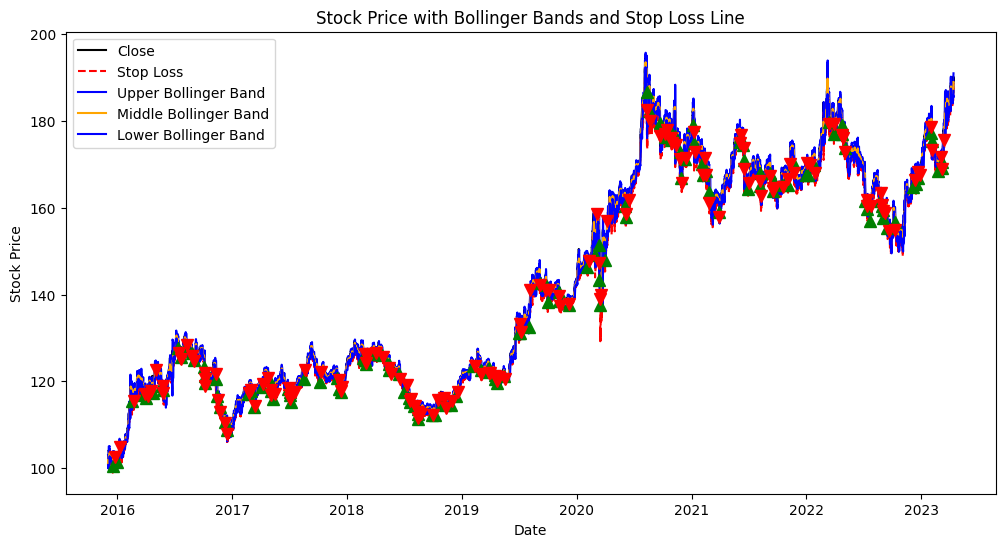

In [25]:


fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot closing prices
ax1.plot(ticker_data.index, ticker_data['Close'], label='Close', color='black')

# Calculate stop loss line at 3 * ATR below current price
stop_loss_line = ticker_data['Close'] - 3 * ticker_data['ATR']
ax1.plot(ticker_data.index, stop_loss_line, label='Stop Loss', color='red', linestyle='--')

# Plot Bollinger Bands
ax1.plot(ticker_data.index, ticker_data['bb_upper'], label='Upper Bollinger Band', color='blue')
ax1.plot(ticker_data.index, ticker_data['bb_middle'], label='Middle Bollinger Band', color='orange')
ax1.plot(ticker_data.index, ticker_data['bb_lower'], label='Lower Bollinger Band', color='blue')

# Plot long entries and exits
for signal in buy_signals:
    ax1.plot(signal[0], signal[1], marker='^', markersize=8, color='g')
for signal in long_exit_signals:
    ax1.plot(signal[0], signal[1], marker='v', markersize=8, color='r')

ax1.set_title('Stock Price with Bollinger Bands and Stop Loss Line')
ax1.set_xlabel('Date')
ax1.set_ylabel('Stock Price')

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
ax1.legend(lines1, labels1, loc='best')

plt.show()




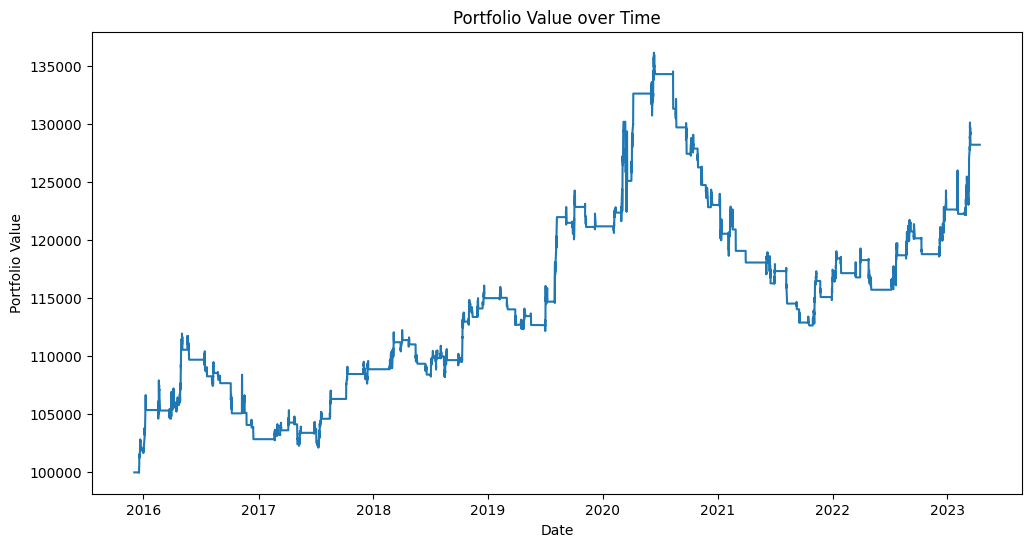

In [26]:
# Plot portfolio value over time
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(ticker_data.index, portfolio_value[1:])
ax.set_xlabel('Date')
ax.set_ylabel('Portfolio Value')
ax.set_title('Portfolio Value over Time')
plt.show()


In [27]:
# Calculate win rate
wins = 0
losses = 0

for i in range(1, len(portfolio_value)):
    if portfolio_value[i] > portfolio_value[i-1]:
        wins += 1
    elif portfolio_value[i] < portfolio_value[i-1]:
        losses += 1

total_trades = wins + losses
win_rate = wins / total_trades

print(f"Total Trades: {total_trades}")
print(f"Wins: {wins}")
print(f"Losses: {losses}")
print(f"Win Rate: {win_rate*100:.2f}%")


Total Trades: 4442
Wins: 2265
Losses: 2177
Win Rate: 50.99%


### Web Socket Connection

In [28]:
# !pip install nest_asyncio
# import nest_asyncio
# nest_asyncio.apply()

In [29]:
# Initiate Class Instance
stream = Stream(API_KEY,
                SECRET_KEY,
                base_url=URL('https://paper-api.alpaca.markets'),
                data_feed='iex')

                

In [30]:
async def trade_callback(t):
    print("aloha")
    print("trade", t)


async def quote_callback(q):
    print("quote", q)

In [31]:
# subscribing to event
stream.subscribe_trades(trade_callback, 'AAPL')
stream.subscribe_quotes(quote_callback, 'IBM')
    
stream.run()



RuntimeError: asyncio.run() cannot be called from a running event loop

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=27261bfa-2227-434f-a801-6477ff735dd9' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>